# *Modelo de Optimización para la Demanda de Queso Costeño*

El modelo de optimización presentado está diseñado para gestionar la demanda de queso costeño a través de una plataforma de marketplace, utilizando múltiples centros de acopio. Su objetivo principal es minimizar los costos asociados con el cumplimiento de la demanda del cliente, considerando los costos de transporte, tiempos de alistamiento y producción potencial en cada centro. El modelo busca reducir los costos totales de distribución en un sistema complejo que involucra un centro principal y varios centros secundarios, asegurando que se satisfaga la demanda total con la menor inversión en costos posible, mientras se cumplen las restricciones de capacidad y tiempo.

**Variables del Problema**

**N**: Número de centros de acopio.

**CAi**: Identificador del centro de acopio i para i=0…N donde i≠p. Estos centros de acopio complementan las unidades de producto de la demanda que el centro de acopio principal no tiene disponibles. Los centros de acopio **CAi** despachan hacia el centro de acopio principal.

**CAp**: Identificador del centro de acopio principal p (**p**∈[0,N] y **p**≠i). Este centro de acopio atiende directamente al cliente y es responsable de enviar la demanda completa al cliente.

**K(CAi)**: Cantidad del producto que se despacha desde el centro de acopio **CAi**, incluyendo unidades en stock y unidades potenciales que pueden estar listas en poco tiempo.

**Precio(CAi)**: Precio por kilo del producto despachado desde el centro de acopio **CAi**.

**cTransp(CAi)**: Costo del transporte del pedido desde el centro de acopio **CAi** a su destino.

**TiempoAlistam(CAi)**: Tiempo en horas para alistar el pedido desde el centro de acopio **CAi** a su destino.

**TiempoMaxDefinido**: Tiempo máximo definido para considerar la producción potencial.

**TiempoTransp(CAi)**: Tiempo de transporte desde el centro de acopio **CAi** a su destino.

**Tiempo(CAi)**: Tiempo total en horas para que el pedido llegue desde el centro de acopio **CAi** a su destino, sumando el tiempo de alistamiento y el tiempo de transporte.

**cTiempo**: Costo adicional por cada unidad de tiempo contemplado en la variable **Tiempo(CAi)**.

**Demanda**: Cantidad de producto solicitada por el cliente.

**Stock(CAi)**: Stock del producto en el centro de acopio **CAi**.

**Ppotencial(CAi)**: Cantidad de producto que potencialmente puede estar disponible en poco tiempo (potencial del día).

*Código desarrollado para la resolución del problema*

# IMPORTACIONES

In [41]:
from pyomo.environ import *
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from prettytable import PrettyTable
import openpyxl
import time

# ENTRADA DE DATOS

**demanda**: Cantidad de producto de acuerdo con la categoría del pedido a satisfacer.

**costo_transporte**: Costo por unidad de tiempo de espera para satisfacer la demanda.

**id**: Identificadores de Centro de Acopio (CAi).

**kg**: Stock del Producto en el Centro de Acopio (Stock(CAi)).

**produccion_potencial**: (Ppotencial(CAi)).

**costos_transporte**: (cTransp(CAi)).

**precio**: Precio del Producto por Kilo (Precio(CAi)).

**tiempos_transporte**:Tiempos de Transporte (TiempoTransp(CAi)).

**tiempo_alistamiento**:Tiempos de Alistamiento (TiempoAlistam(CAi)).

In [42]:
centros_acopio_df = pd.read_excel('data/centros_acopiodos.xlsx')
tiempos_transporte_df = pd.read_excel('data/tiempos_transporte.xlsx')
costo_transporte_df = pd.read_excel('data/costo_transporte.xlsx')

# REPRESENTACIÓN DE DATOS DE ENTRADA

In [43]:
centros_acopio = centros_acopio_df.copy()
headers = ["Id_CA", "Cantidad", "Precio", "Ctransp", "TiempoTransp", "TiempoAlistam"]
table = [[row["Id_CA"], row["Cantidad"], row["Precio"], row["Ctransp"], row["TiempoTransp"], row["TiempoAlistam"]] for _, row in centros_acopio.iterrows()]

print("Centros de Acopio:")
print(tabulate(table, headers=headers, tablefmt='grid'))
print()

costo_transporte_df.columns = [''] + list(costo_transporte_df.columns[1:])
tiempos_transporte_df.columns = [''] + list(tiempos_transporte_df.columns[1:])

print("Matriz 'Costos de Transporte':")
print(tabulate(costo_transporte_df, tablefmt='grid', showindex=False, headers='keys'))
print()

table = PrettyTable()
table.field_names = costo_transporte_df.columns.tolist()
for row in costo_transporte_df.values:
    table.add_row(list(row))

print("Tabla 'Costos de Transporte':")
print(table)
print()

print("Matriz 'Tiempos de Transporte':")
print(tabulate(tiempos_transporte_df, tablefmt='grid', showindex=False, headers='keys'))
print()

table = PrettyTable()
table.field_names = tiempos_transporte_df.columns.tolist()
for row in tiempos_transporte_df.values:
    table.add_row(list(row))

print("Tabla 'Tiempos de Transporte':")
print(table)
print()

Centros de Acopio:
+---------+------------+----------+-----------+----------------+-----------------+
|   Id_CA |   Cantidad |   Precio |   Ctransp |   TiempoTransp |   TiempoAlistam |
+=========+============+==========+===========+================+=================+
|       1 |     10     |     5000 |     28862 |             44 |               0 |
+---------+------------+----------+-----------+----------------+-----------------+
|       1 |      0.5   |     5000 |     28862 |             44 |              10 |
+---------+------------+----------+-----------+----------------+-----------------+
|       2 |     12     |    10000 |     12897 |             17 |               0 |
+---------+------------+----------+-----------+----------------+-----------------+
|       2 |      0.625 |    10000 |     12897 |             17 |               9 |
+---------+------------+----------+-----------+----------------+-----------------+
|       3 |      4     |    15000 |     23705 |             35 |    

# FUNCIÓN DE MINIMIZACIÓN DE LOS COSTOS DE DISTRIBUCIÓN

Este modelo cuenta con una función principal llamada minimize_distribution_costs, la cual realiza una optimización para determinar la mejor manera de despachar y transportar productos entre centros de acopio principal hasta el cliente, minimizando los costos. A continuación, se presenta un resumen de su contenido:

**1. Creación del Modelo:** Se define un modelo de optimización usando Pyomo (pyo.ConcreteModel()).

**2. Conjunto de datos:** La función utiliza un conjunto de centros de acopio, definido por el rango desde 0 hasta el número total de centros menos uno. Este conjunto es utilizado para indexar las variables y parámetros en el modelo.

**3. Definición de parámetros:** Los parámetros son fundamentales para la optimización, ya que incluyen la cantidad total que debe ser satisfecha, los costos asociados al tiempo de alistamiento y los precios de los productos en los diferentes centros. También gestionan datos sobre el stock y el potencial de cada centro, así como los costos y tiempos de transporte. Adicionalmente, se establece un límite máximo de tiempo para alistamiento y transporte, y se define el centro de acopio principal que se evaluará. Estos parámetros permiten al modelo gestionar de manera eficiente la distribución de productos y minimizar los costos totales.

**4. Variables de decisión:** El modelo define dos tipos de variables: X, que representa la cantidad despachada desde cada centro, y Y, que representa la cantidad transportada entre centros. Ambas variables están restringidas a valores no negativos.

**5. Función Objetivo:**

\begin{equation}
\text{Minimizar} \quad \sum_{i=1, i \neq p}^{N} \left[ K(CAi) \cdot Precio(CAi) + K(CAi) \cdot cTransp(CAi) + Tiempo(CAi) \cdot cTiempo \right] + \left[ K(CAp) \cdot Precio(CAp) + Demanda \cdot cTransp(CAp) + Tiempo(CAp) \cdot cTiempo \right]
\end{equation}

La función objetivo para minimizar costos se puede desglosar en dos partes principales:

a. **Costo de los centros de acopio que no son el principal (i ≠ p):**
   
\begin{equation}
\quad \sum_{i=1, i \neq p}^{N} \left[ K(CAi) \cdot Precio(CAi) + K(CAi) \cdot cTransp(CAi) + Tiempo(CAi) \cdot cTiempo \right] +
\end{equation}

   - **K(CAi)** es el stock en el centro de acopio \( i \).
   - **Precio(CAi)** es el precio en el centro de acopio \( i \).
   - **cTransp(CAi** es el costo de transporte desde el centro de acopio \( i \).
   - **Tiempo(CAi)** es el tiempo asociado al centro de acopio \( i \).
   - **cTiempo** es el costo asociado al tiempo.

   *Este término representa el costo total de todos los centros de acopio que no son el principal.*

b. **Costo del centro de acopio principal (p):**

   
\begin{equation}
 \left[ K(CAp) \cdot Precio(CAp) + Demanda \cdot cTransp(CAp) + Tiempo(CAp) \cdot cTiempo \right]
\end{equation}
   

   - **K(CAp** es el stock en el centro de acopio principal.
   - **Precio(CAp)** es el precio en el centro de acopio principal.
   - **Demanda** es la demanda total.
   - **cTransp(CAp)** es el costo de transporte desde el centro de acopio principal.
   - **Tiempo(CAp)** es el tiempo asociado al centro de acopio principal.
   - **cTiempo** es el costo asociado al tiempo.

   *Este término representa el costo asociado al centro de acopio principal.*

La función objetivo `objective_rule` en Pyomo se compone de dos partes principales:

a. **Primera Parte**:
   - Calcula los costos asociados a los productos por despachar, el transporte y el tiempo de alistamiento para todos los centros de acopio excepto el centro principal.
   
b. **Segunda Parte**:
   - Calcula los costos de productos despachados, el transporte necesario para satisfacer la demanda total y el tiempo de alistamiento específicamente para el centro principal.

Esto asegura que el modelo minimice los costos totales de operación, teniendo en cuenta los diferentes costos involucrados y priorizando el uso del centro principal cuando sea posible.

**6. Restricciones:**

\begin{equation}
\sum_{i=0}^{N} K(CAi) = Demanda
\end{equation}

\begin{equation}
K(CAi) \leq Stock(CAi) + P_{\text{potencial}}(CAi) \quad \text{para } i=0\ldots N
\end{equation}

\begin{equation}
Tiempo(CAi) = Tiempo_{\text{Alistam}}(CAi) + Tiempo_{\text{Transp}}(CAi)
\end{equation}

\begin{equation}
Tiempo_{\text{Alistam}}(CAi) \leq Tiempo_{\text{MaxDefinido}} \quad \text{para } i=0\ldots N
\end{equation}

La restricciones funcionan de esta manera:

a. **Sumatoria del stock igual a la demanda total:**

La restricción se expresa de la siguiente manera:

\begin{equation}
\sum_{i=0}^{N} K(CAi) = Demanda
\end{equation}

   - **K(CAi)** es el stock en el centro de acopio \( i \).
   - **Demanda** es la demanda total.

   Esta ecuación garantiza que la suma del stock disponible en todos los centros de acopio sea igual a la demanda total. En el código esta restricción asegura que la suma de todas las cantidades asignadas (model.X[i]) debe ser igual a la demanda total (model.demanda). Aquí, model.I representa el conjunto de índices de los centros de distribución.

b. **Stock limitado por el inventario disponible y potencial:**

La restricción se expresa de la siguiente manera:

\begin{equation}
K(CAi) \leq Stock(CAi) + P_{\text{potencial}}(CAi) \quad \text{para } i=0\ldots N
\end{equation}

   - **K(CAi)** es el stock en el centro de acopio \( i \).
   - **Stock(CAi)** es el inventario disponible en el centro de acopio \( i \).
   - **P_potencial(CAi)** es el inventario potencial adicional que se puede obtener en el centro de acopio \( i \).

   Esta ecuación garantiza que el stock en cada centro de acopio no exceda la suma del inventario disponible y el inventario potencial adicional. En el código esta restricción asegura que la cantidad asignada en cada centro de distribución i (model.X[i]) no exceda la suma del stock disponible (model.Stock[i]) y el stock potencial (model.Ppotencial[i]) en ese centro. La regla se aplica a cada centro de distribución en el conjunto model.I.

c. **Tiempo total en cada centro de acopio:**

La restricción se expresa de la siguiente manera:

\begin{equation}
Tiempo(CAi) = Tiempo_{\text{Alistam}}(CAi) + Tiempo_{\text{Transp}}(CAi)
\end{equation}

   - **Tiempo(CAi)** es el tiempo total asociado al centro de acopio \( i \).
   - **Tiempo_Alistam(CAi)** es el tiempo de alistamiento en el centro de acopio \( i \).
   - **Tiempo_Transp(CAi)** es el tiempo de transporte desde el centro de acopio \( i \).

   Esta ecuación garantiza el tiempo total en cada centro de acopio como la suma del tiempo de alistamiento y el tiempo de transporte.

d. **Límite en el tiempo de alistamiento:**

La restricción se expresa de la siguiente manera:

\begin{equation}
Tiempo_{\text{Alistam}}(CAi) \leq Tiempo_{\text{MaxDefinido}} \quad \text{para } i=0\ldots N
\end{equation}

   - **Tiempo_Alistam(CAi)** es el tiempo de alistamiento en el centro de acopio \( i \).
   - **Tiempo_MaxDefinido** es el tiempo máximo permitido para el alistamiento.

   Esta ecuación garantiza que el tiempo de alistamiento en cada centro de acopio no exceda el tiempo máximo permitido definido previamente.

En el código las restricciones c y d aseguran que el tiempo de alistamiento en el centro i (model.TiempoAlistam[i]) más el tiempo total de transporte desde el centro i a otros centros (model.tiempos_transporte[i, j] * model.Y[i, j]) no exceda un tiempo máximo definido (model.tiempo_maximo_definido). Este tiempo máximo incluye el tiempo necesario para considerar la producción potencial, asegurando que toda la operación se complete dentro del tiempo permitido para maximizar la producción. Esta regla se aplica a cada centro de distribución en model.I.

e. **Balance de Transporte**

\begin{equation}
\sum_{j \in I} Y_{j, i} = X_i \quad \text{para cada } i \neq \text{CentroPrincipal}
\end{equation}
 La ecuación garantiza que para cada centro de acopio que no sea el principal, la cantidad total de productos recibidos desde otros centros sea igual a la cantidad que ese centro despacha. Esto es esencial para mantener el equilibrio y la consistencia en el sistema de distribución. En el código esta restricción asegura que la cantidad total transportada hacia un centro i (sum(model.Y[j, i] for j in model.I)) sea igual a la cantidad despachada desde ese centro (model.X[i]), pero solo para los centros que no son el centro principal (i != model.CentroPrincipal). Para el centro principal, esta restricción se omite (pyo.Constraint.Skip), porque el centro principal maneja directamente la demanda y no se transporta nada hacia él.

f. **Manejo del Centro Principal**


La restricción se expresa de la siguiente manera:

\begin{equation}
\sum_{i \in I} Y_{i, \text{(CAp)}} = X_{\text{(CAp)}}
\end{equation}



La ecuación garantiza que la cantidad total recibida por el centro principal (de otros centros) sea igual a la cantidad que el centro principal debe despachar, a menos que se trate del centro principal en sí mismo. En el código esta restricción asegura que la suma de las cantidades transportadas desde otros centros i al centro principal (model.Y[i, model.CentroPrincipal]) sea igual a la cantidad asignada en el centro principal (model.X[model.CentroPrincipal]).


**7. Resolución del Modelo**

**Uso de un Solver:** Se utiliza el solver *GLPK* para resolver el modelo y encontrar la solución óptima.

**8. Recalibración de Costos**

**Recalculo del Costo de Tiempo:** Se ajusta el costo de tiempo utilizando los resultados iniciales y el modelo se actualiza mediante la modificación de la función objetivo.

**9. Resolución de actualización del Modelo**

Se resuelve de nuevo para reflejar los cambios.

**10. Solución óptima**

Se identifican los centros involucrados en la red de distribución. Se determina el centro principal, que es responsable de satisfacer la demanda del cliente, mientras se asigna una cantidad específica a cada centro. Se evalúan los costos de transporte desde cada centro hasta el principal, lo que permite calcular el costo total objetivo asociado con la demanda del cliente.

In [74]:
import pyomo.environ as pyo

def minimize_distribution_costs(centro_principal_id, centros_acopio_df, tiempos_transporte_df, costo_transporte_df):
    # 1. Creación del modelo
    model = pyo.ConcreteModel()

    # 2. Conjunto de datos
    num_centros = len(centros_acopio_df) // 2  # Se dividen en stock y producción potencial
    model.I = pyo.RangeSet(0, num_centros - 1)  # Conjunto de centros de acopio
    
    # 3. Definición de parámetros
    model.demanda = pyo.Param(initialize=60)  # Demanda total a satisfacer
    model.costo_tiempo = pyo.Param(initialize=100, mutable=True)  # Costo por unidad de tiempo
    model.Costo_Por_Unidad_De_Tiempo = pyo.Param(initialize=60.0, mutable=True, within=pyo.NonNegativeReals)
    
    # Separar stock y producción potencial
    stock = centros_acopio_df.iloc[::2]  # Filas impares: stock
    produccion_potencial = centros_acopio_df.iloc[1::2]  # Filas pares: producción potencial
    
    model.Stock = pyo.Param(model.I, initialize={i: stock.iloc[i]['Cantidad'] for i in model.I})  # Stock
    model.Ppotencial = pyo.Param(model.I, initialize={i: produccion_potencial.iloc[i]['Cantidad'] for i in model.I})  # Producción potencial
    model.Precio = pyo.Param(model.I, initialize={i: stock.iloc[i]['Precio'] for i in model.I})  # Precio
    model.CTransp = pyo.Param(model.I, initialize={i: stock.iloc[i]['Ctransp'] for i in model.I})  # Costo transporte
    model.TiempoTransp = pyo.Param(model.I, initialize={i: stock.iloc[i]['TiempoTransp'] for i in model.I})  # Tiempo transporte
    model.TiempoAlistam = pyo.Param(model.I, initialize={i: stock.iloc[i]['TiempoAlistam'] for i in model.I})  # Tiempo de alistamiento
    
    # Matrices de transporte y tiempos entre centros
    model.costos_transporte = pyo.Param(model.I, model.I, initialize={(i, j): costo_transporte_df.iloc[i, j + 1] for i in model.I for j in model.I})
    model.tiempos_transporte = pyo.Param(model.I, model.I, initialize={(i, j): tiempos_transporte_df.iloc[i, j + 1] for i in model.I for j in model.I})
    model.tiempo_maximo_definido = pyo.Param(initialize=360)  # Tiempo máximo permitido
    model.CentroPrincipal = pyo.Param(initialize=centro_principal_id - 1)  # Convert to zero-based index

    
    # 4. Variables de decisión
    model.X = pyo.Var(model.I, within=pyo.NonNegativeReals)  # Cantidad despachada desde cada centro
    model.Y = pyo.Var(model.I, model.I, within=pyo.NonNegativeReals)  # Cantidad transportada entre centros
    
    # 5. Función Objetivo
    def objective_rule(model):
        total_cost = sum(
            model.X[i] * model.Precio[i] +
            model.CTransp[i] + 
            (model.TiempoTransp[i] + model.TiempoAlistam[i]) * model.costo_tiempo +
            model.X[model.CentroPrincipal] * model.Precio[model.CentroPrincipal] +
            model.CTransp[model.CentroPrincipal] + 
            model.TiempoTransp[model.CentroPrincipal] * model.costo_tiempo
            for i in model.I
        )
        return total_cost

    model.CostoTotal = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

    # 6. Restricciones
    # a) Satisfacer la demanda
    model.DemandaSatisfecha = pyo.Constraint(expr=sum(model.X[i] for i in model.I) == model.demanda)
    
    # b) No despachar más de lo disponible en stock + producción potencial
    model.CombinedStockPotential = pyo.Constraint(model.I, rule=lambda model, i: model.X[i] <= model.Stock[i] + model.Ppotencial[i])
    
    # c) Restricción de tiempo de alistamiento y transporte
    model.CombinedTiempoTotalAlistamMax = pyo.Constraint(model.I, rule=lambda model, i: model.TiempoAlistam[i] + sum(model.tiempos_transporte[i, j] * model.Y[i, j] for j in model.I) <= model.tiempo_maximo_definido)
    
    # d) Balance de transporte entre centros
    def balance_transport_rule(model, i):
        if i != model.CentroPrincipal:
            return sum(model.Y[j, i] for j in model.I) == model.X[i]
        else:
            return pyo.Constraint.Skip

    model.BalanceTransport = pyo.Constraint(model.I, rule=balance_transport_rule)
    
    # e) El centro principal maneja su propio stock
    model.CentroPrincipalStock = pyo.Constraint(expr=model.X[model.CentroPrincipal] <= model.Stock[model.CentroPrincipal])

    # 7. Resolución del Modelo
    solver = pyo.SolverFactory('glpk')
    results = solver.solve(model)
    
    # 8. Recalibración de Costos
    Costo_Total = pyo.value(model.CostoTotal)
    costo_tiempo_actualizado = model.tiempo_maximo_definido() / Costo_Total
    model.costo_tiempo.set_value(costo_tiempo_actualizado)
    
    # 9. Resolución del Modelo actualizado
    results = solver.solve(model, tee=True)
    
    # 10. Resultados
    total_costo_transporte = 0
    centros_despachados = set()

    for i in model.I:
        for j in model.I:
            if model.Y[i, j].value is not None:  # Verificar si Y[i,j] tiene un valor
                value_Y = pyo.value(model.Y[i, j])
                if value_Y > 0:
                    centros_despachados.add(i)
                    centros_despachados.add(j)
    
    for i in model.I:
        if i != model.CentroPrincipal:
            cantidad_transportada = sum(pyo.value(model.Y[i, j]) for j in model.I if pyo.value(model.Y[i, j]) > 0)
            if cantidad_transportada > 0:
                costo_transportado = cantidad_transportada * model.CTransp[i]
                total_costo_transporte += costo_transportado

    print(f"\nCentros seleccionados para la operación:")
    for centro in centros_despachados:
        print(f"Centro {centro + 1}")
    
    print(f"\nCentro principal seleccionado: {model.CentroPrincipal.value + 1}")
    
    print("\nCantidad asignada:")
    for i in model.I:
        cantidad_asignada = pyo.value(model.X[i])
        print(f"Centro {i + 1}: {cantidad_asignada:.2f}")
    print(f'\nCosto total del transporte desde centros al centro {centro_principal_id} como Centro Principal = ${total_costo_transporte:,.2f}')
    return pyo.value(model.CostoTotal), total_costo_transporte

# ANÁLISIS DE COSTOS Y TIEMPOS DE EJECUCIÓN

Se itera sobre todos los centros para calcular los costos considerando cada uno como centro principal. Estos datos se presentan en una tabla para identificar cuál de los centros ofrece el costo más óptimo para ser el centro principal definitivo.


*** Optimizando para el Centro 1 como Centro Principal ***
GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmp6q36fvu3.glpk.raw --wglp /tmp/tmp_wdc2uu2.glpk.glp --cpxlp
 /tmp/tmp3_it7xgh.pyomo.lp
Reading problem data from '/tmp/tmp3_it7xgh.pyomo.lp'...
31 rows, 110 columns, 210 non-zeros
433 lines were read
Writing problem data to '/tmp/tmp_wdc2uu2.glpk.glp'...
388 lines were written
GLPK Simplex Optimizer 5.0
31 rows, 110 columns, 210 non-zeros
Preprocessing...
20 rows, 99 columns, 189 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  4.700e+01  ratio =  4.700e+01
GM: min|aij| =  7.118e-01  max|aij| =  1.405e+00  ratio =  1.974e+00
EQ: min|aij| =  5.080e-01  max|aij| =  1.000e+00  ratio =  1.968e+00
Constructing initial basis...
Size of triangular part is 20
      0: obj =   3.781139244e+06 inf =   4.993e+01 (1)
      4: obj =   1.784639244e+06 inf =   0.000e+00 (0)
*     7: obj =   1.040014244e+06 inf =   0.000e+00 (0)
OPTIMAL LP SO

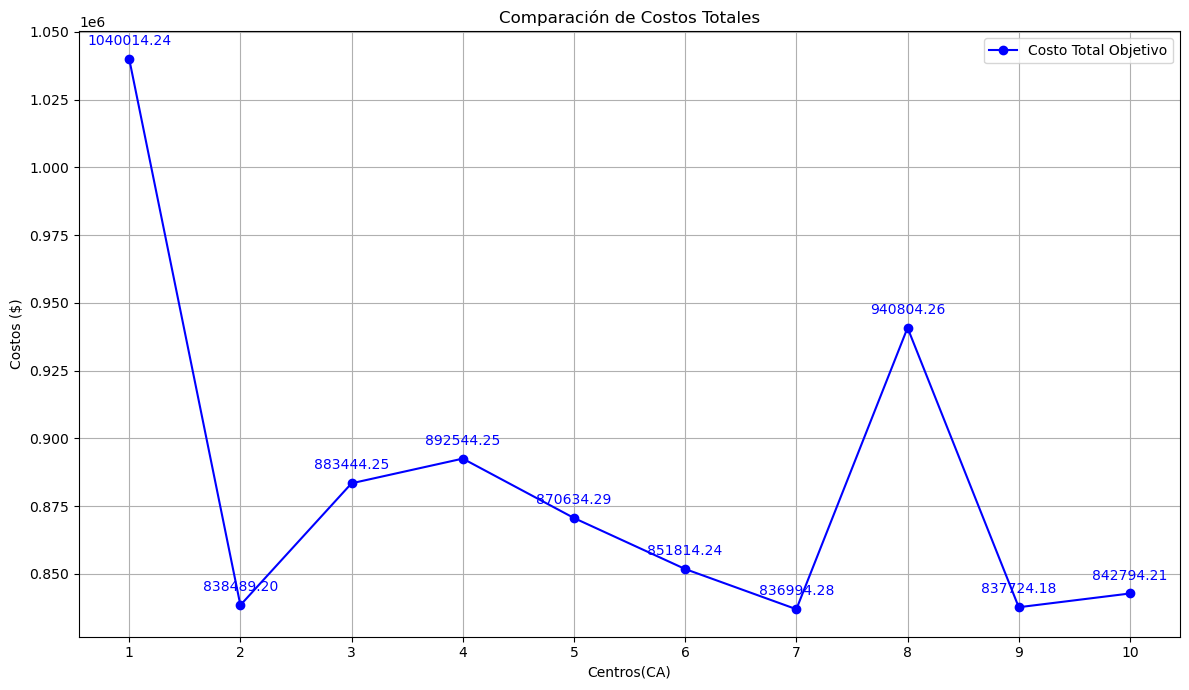

In [108]:
# Resultados y tiempos de ejecución
resultados = {}
tiempos_ejecucion = []
num_iteraciones = 0

for centro_id in range(len(centros_acopio_df) // 2):
    num_iteraciones += 1
    print(f'\n*** Optimizando para el Centro {centro_id + 1} como Centro Principal ***')

    start_time = time.time()

    # Aquí llamamos a tu función de optimización, asegúrate de que centro_principal_id siempre sea positivo
    try:
        resultado_optimizacion = minimize_distribution_costs(
            centro_principal_id=centro_id + 1,  # Corregido para que inicie desde 1
            centros_acopio_df=centros_acopio_df,
            tiempos_transporte_df=tiempos_transporte_df,
            costo_transporte_df=costo_transporte_df
        )
    except KeyError as e:
        print(f"Error: {e}")
        continue  # Saltar iteración si ocurre un KeyError

    end_time = time.time()
    elapsed_time = end_time - start_time
    tiempos_ejecucion.append(elapsed_time)

    # Extraemos el costo total y el costo de transporte del resultado
    costo_total_valor, costo_transporte_valor = resultado_optimizacion

    resultados[f'{centro_id + 1}'] = {
        'costo_total': costo_total_valor,
        'costo_transporte': costo_transporte_valor,
        'tiempo_ejecucion': elapsed_time
    }
    #print(f'Costo de transporte para el centro {centro_id + 1} = ${costo_transporte_valor:,.2f}')
    print(f'Objetivo de costo total para el centro {centro_id + 1} como Centro Principal = ${costo_total_valor:,.2f}')
    print(f'Tiempo de ejecución: {elapsed_time:.2f} segundos\n\n')

# Cálculo del tiempo promedio de ejecución
promedio_tiempo = sum(tiempos_ejecucion) / len(tiempos_ejecucion)

# Imprimir separador
for _ in range(115):
    print('-', end='')
print()

# Tabla de resultados
print('\n\nTabla de costos objetivos, costos de transporte y tiempos de ejecución: \n')

tabla = [[centro, 
          f"${datos['costo_total']:,.2f}", 
          #f"${datos['costo_transporte']:,.2f}", 
          f"{datos['tiempo_ejecucion']:.2f} segundos"]
         for centro, datos in resultados.items()]
headers = ["Centro", "Costo Total Objetivo", "Costo de Transporte", "Tiempo de Ejecución"]
print(tabulate(tabla, headers, tablefmt="grid"))

# Determinar el centro con el menor costo total
centro_menor_costo = min(resultados, key=lambda x: resultados[x]['costo_total'])
costo_menor = resultados[centro_menor_costo]['costo_total']

# Imprimir resultados finales
print(f'\nEl centro con el costo total más óptimo es el Nº {centro_menor_costo}.')
print(f'Tiempo promedio de ejecución es: {promedio_tiempo:.2f} segundos')

# Preparar datos para la visualización
centros = list(resultados.keys())
costos_totales = [resultados[centro]['costo_total'] for centro in centros]
costos_transporte = [resultados[centro]['costo_transporte'] for centro in centros]

# Crear gráfico
plt.figure(figsize=(12, 7))

plt.plot(centros, costos_totales, marker='o', linestyle='-', color='blue', label='Costo Total Objetivo')
#plt.plot(centros, costos_transporte, marker='o', linestyle='--', color='orange', label='Costo de Transporte')

# Anotaciones en el gráfico
for i, txt in enumerate(costos_totales):
    plt.annotate(f'{txt:.2f}', (centros[i], costos_totales[i]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
#for i, txt in enumerate(costos_transporte):
#    plt.annotate(f'{txt:.2f}', (centros[i], costos_transporte[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='orange')

plt.xlabel('Centros(CA)')
plt.ylabel('Costos ($)')
plt.title('Comparación de Costos Totales')
#plt.title('Comparación de Costos Totales y Costos de Transporte por Centro')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# RESULTADOS

Se selecciona el centro de acopio principal de manera definitiva y se optimiza el modelo eligiendo el centro de acopio con el menor costo de transporte al cliente.

In [96]:
try:
    start_time = time.time()
    centro_principal_optimo = centros_acopio_df['Ctransp'].idxmin()
    
    print(f'\nCentro Principal Definitivo: {centro_principal_optimo}\n')
    
    costo_total_optimo, total_costo_transporte = minimize_distribution_costs(
        centro_principal_id=centro_principal_optimo,
        centros_acopio_df=centros_acopio_df,
        tiempos_transporte_df=tiempos_transporte_df,
        costo_transporte_df=costo_transporte_df,
    )
    print(f'\nCosto total desde Centro Principal {centro_principal_optimo} = ${costo_total_optimo:,.2f}\n')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Tiempo de ejecución: {elapsed_time:.2f} segundos')
    print(f'Tiempo promedio de ejecución es de {promedio_tiempo:.2f} segundos con un total de {num_iteraciones} iteraciones.')

except Exception as e:
    print(f"Error al optimizar con el centro de acopio con menor costo de transporte al cliente: {e}")


Centro Principal Definitivo: 7

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmp16fuf4tl.glpk.raw --wglp /tmp/tmpcjryn2_9.glpk.glp --cpxlp
 /tmp/tmpf7_iskhf.pyomo.lp
Reading problem data from '/tmp/tmpf7_iskhf.pyomo.lp'...
31 rows, 110 columns, 210 non-zeros
433 lines were read
Writing problem data to '/tmp/tmpcjryn2_9.glpk.glp'...
388 lines were written
GLPK Simplex Optimizer 5.0
31 rows, 110 columns, 210 non-zeros
Preprocessing...
20 rows, 99 columns, 189 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  4.700e+01  ratio =  4.700e+01
GM: min|aij| =  7.118e-01  max|aij| =  1.405e+00  ratio =  1.974e+00
EQ: min|aij| =  5.080e-01  max|aij| =  1.000e+00  ratio =  1.968e+00
Constructing initial basis...
Size of triangular part is 20
      0: obj =   1.028311928e+07 inf =   4.773e+01 (1)
      4: obj =   2.825619284e+06 inf =   0.000e+00 (0)
*     7: obj =   8.369942841e+05 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0